# **ADS 502 Final Project - Death Classification**
### Team 5 - Katie Mears, Marvin Moran, Claire Bentzen

## 1. Introduction

##### Load Packages

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# !pip install prince
import prince
from scipy.stats import chi2_contingency
import networkx as nx
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve


In [46]:
import warnings
warnings.filterwarnings('ignore')

##### Read and Examine Dataset

In [47]:
# Read in 2015_data.csv
death_data = pd.read_csv('2015_data.csv')

# Display the first few rows of the data
print(death_data.head())

   resident_status  education_1989_revision  education_2003_revision  \
0                1                      NaN                      3.0   
1                1                      NaN                      6.0   
2                1                      NaN                      3.0   
3                1                      NaN                      3.0   
4                1                      NaN                      5.0   

   education_reporting_flag  month_of_death sex  detail_age_type  detail_age  \
0                         1               1   M                1          84   
1                         1               1   M                1          70   
2                         1               1   F                1          91   
3                         1               1   F                1          40   
4                         1               1   F                1          89   

   age_substitution_flag  age_recode_52  ...  record_condition_18  \
0                

In [48]:
# Print shape of data
death_data.shape
total = death_data.shape[0]

In [49]:
# Print Column Titles in Original Data Set
column_titles = death_data.columns
print(column_titles)

Index(['resident_status', 'education_1989_revision', 'education_2003_revision',
       'education_reporting_flag', 'month_of_death', 'sex', 'detail_age_type',
       'detail_age', 'age_substitution_flag', 'age_recode_52', 'age_recode_27',
       'age_recode_12', 'infant_age_recode_22',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code',
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_',
       'icd_code_10th_revision', '358_cause_recode', '113_cause_recode',
       '130_infant_cause_recode', '39_cause_recode',
       'number_of_entity_axis_conditions', 'entity_condition_1',
       'entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition

## 2. Feature Selection

In [50]:
# Print Missing Values per Column
missing_values_count = death_data.isnull().sum()
print(missing_values_count)

resident_status                     0
education_1989_revision       2645155
education_2003_revision         73043
education_reporting_flag            0
month_of_death                      0
                               ...   
race_imputation_flag          2692049
race_recode_3                       0
race_recode_5                       0
hispanic_origin                     0
hispanic_originrace_recode          0
Length: 77, dtype: int64


In [51]:
# Print Missing Data as percentage (per column)
total_rows = death_data.shape[0]
percent_missing = (missing_values_count / total_rows) * 100
print(percent_missing)

resident_status                0.000000
education_1989_revision       97.312815
education_2003_revision        2.687185
education_reporting_flag       0.000000
month_of_death                 0.000000
                                ...    
race_imputation_flag          99.038002
race_recode_3                  0.000000
race_recode_5                  0.000000
hispanic_origin                0.000000
hispanic_originrace_recode     0.000000
Length: 77, dtype: float64


Due to the amount of missing data in certain columns, those columns will be dropped.

In [52]:
# Isolate the Desired Columns
desired_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death', 'method_of_disposition',
                   'autopsy', 'race','detail_age']
new_death = death_data[desired_columns]

# List of column names to convert to categorical
categorical_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death',
                   'method_of_disposition', 'autopsy', 'race']

# Convert the selected columns to categorical
new_death[categorical_columns] = new_death[categorical_columns].astype('category')

In [53]:
# Data Description of original data set with selected columns (2015_data.csv)
data_description_all = new_death.describe(include='all')
print(data_description_all)

        education_2003_revision  month_of_death      sex  \
count                 2645155.0       2718198.0  2718198   
unique                      9.0            12.0        2   
top                         3.0             1.0        M   
freq                  1077604.0        265882.0  1377165   
mean                        NaN             NaN      NaN   
std                         NaN             NaN      NaN   
min                         NaN             NaN      NaN   
25%                         NaN             NaN      NaN   
50%                         NaN             NaN      NaN   
75%                         NaN             NaN      NaN   
max                         NaN             NaN      NaN   

        place_of_death_and_decedents_status marital_status  \
count                             2718198.0        2718198   
unique                                  8.0              5   
top                                     1.0              M   
freq                           

##### Convert response variable to only 2 categories - 0 for not homicide and 1 for homicide

In [54]:
# Convert manner_of_death to homicide or not homicide
new_death['manner_of_death'] = new_death['manner_of_death'].replace([1, 2, 4, 5, 6, 7, None],0)
new_death['manner_of_death'] = new_death['manner_of_death'].replace([3],1)

## 3. Exploratory Data Analysis (Original Data Set)

In [55]:
# Get the data types for all columns
data_types = new_death.dtypes

print(data_types)

education_2003_revision                category
month_of_death                         category
sex                                    category
place_of_death_and_decedents_status    category
marital_status                         category
day_of_week_of_death                   category
injury_at_work                         category
manner_of_death                        category
method_of_disposition                  category
autopsy                                category
race                                   category
detail_age                                int64
dtype: object


#### 3.1 Identify Missing Values

In [56]:
# Print Missing Values per Column
missing_values_count = new_death.isnull().sum()
print(missing_values_count)

education_2003_revision                 73043
month_of_death                              0
sex                                         0
place_of_death_and_decedents_status         0
marital_status                              0
day_of_week_of_death                        0
injury_at_work                              0
manner_of_death                        388364
method_of_disposition                       0
autopsy                                     0
race                                        0
detail_age                                  0
dtype: int64


In [57]:
# Print Missing Data as percentage (per column)
total_rows = new_death.shape[0]
percent_missing = (missing_values_count / total_rows) * 100
print(percent_missing)

education_2003_revision                 2.687185
month_of_death                          0.000000
sex                                     0.000000
place_of_death_and_decedents_status     0.000000
marital_status                          0.000000
day_of_week_of_death                    0.000000
injury_at_work                          0.000000
manner_of_death                        14.287554
method_of_disposition                   0.000000
autopsy                                 0.000000
race                                    0.000000
detail_age                              0.000000
dtype: float64


In [58]:
# Print Total Percent of Missing Data
total_missing_values = new_death.isnull().sum().sum()
total_elements = new_death.size
total_percent_missing = (total_missing_values / total_elements) * 100
print("Total percentage of missing data in the dataset: {:.2f}%".format(total_percent_missing))

Total percentage of missing data in the dataset: 1.41%


#### 3.2 Categorical Data Analysis

##### 3.2.1 education_2003_revision

education_2003_revision Frequency:
3.0    940123
4.0    260030
2.0    241708
1.0    223742
6.0    217504
5.0    134204
9.0    103218
7.0     86253
8.0     34202
Name: education_2003_revision, dtype: int64


[Text(0, 0, '8th grade or less'),
 Text(1, 0, '9 - 12th grade, No Diploma'),
 Text(2, 0, 'HS/GED'),
 Text(3, 0, 'Some College'),
 Text(4, 0, 'Associate Degree'),
 Text(5, 0, "Bachelor's Degree"),
 Text(6, 0, "Master's Degree"),
 Text(7, 0, 'Doctorate or Professional Degree'),
 Text(8, 0, 'Unknown')]

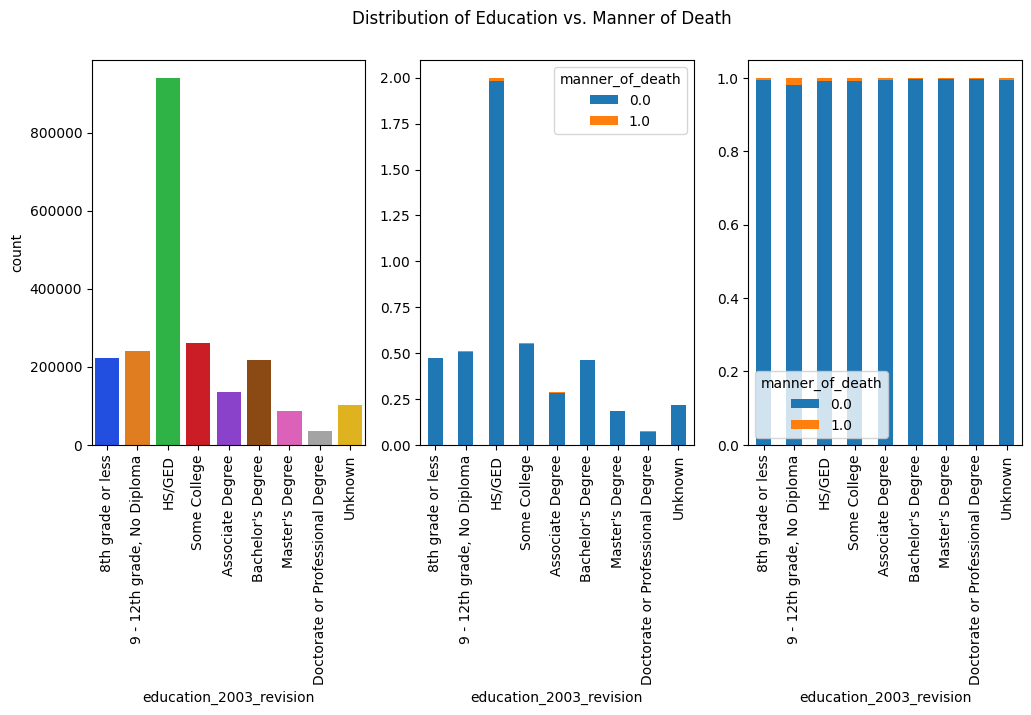

In [178]:
# Value Counts
education_counts = new_death['education_2003_revision'].value_counts()
print("education_2003_revision Frequency:")
print(education_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Education vs. Manner of Death")

# Plot Counts
sns.countplot(x="education_2003_revision", data=new_death, ax=axs[0], palette = "bright")
labels = ["8th grade or less", "9 - 12th grade, No Diploma", "HS/GED", "Some College", "Associate Degree", "Bachelor's Degree", "Master's Degree", "Doctorate or Professional Degree", "Unknown"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_education = pd.crosstab(new_death['education_2003_revision'], new_death['manner_of_death']) / total
crosstab_education.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_education_norm = crosstab_education.div(crosstab_education.sum(axis=1), axis = 0)
crosstab_education_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.2 month_of_death

month_of_death Frequency:
1     220521
3     201701
2     188086
12    187271
4     186339
5     186038
10    183939
7     180719
11    178612
8     178402
6     175388
9     173968
Name: month_of_death, dtype: int64


[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

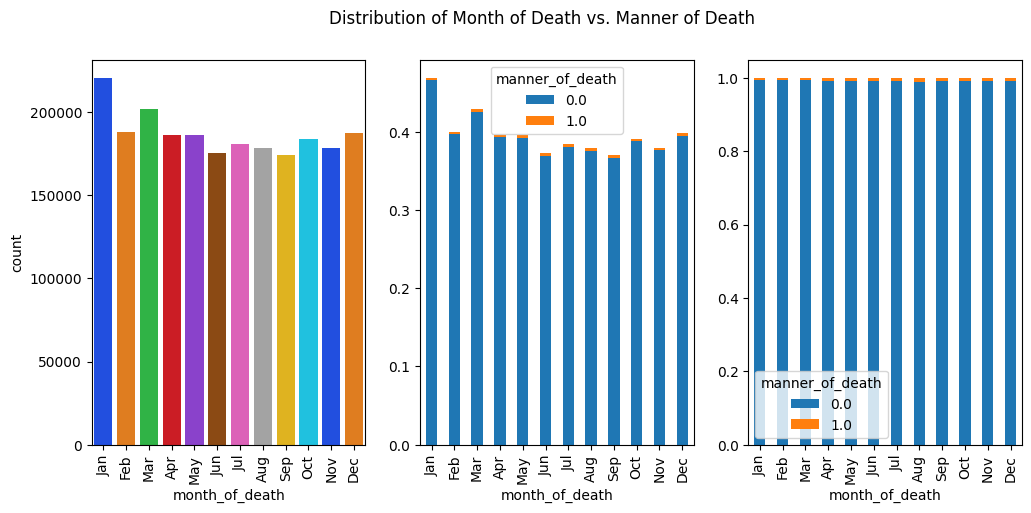

In [179]:
# Value Counts
month_of_death_counts = new_death['month_of_death'].value_counts()
print("month_of_death Frequency:")
print(month_of_death_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Month of Death vs. Manner of Death")

# Plot Counts
sns.countplot(x="month_of_death", data=new_death, ax=axs[0], palette = "bright")
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_month = pd.crosstab(new_death['month_of_death'], new_death['manner_of_death']) / total
crosstab_month.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_month_norm = crosstab_month.div(crosstab_month.sum(axis=1), axis = 0)
crosstab_month_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.3 sex

sex Frequency:
M    1142490
F    1098494
Name: sex, dtype: int64


<Axes: xlabel='sex'>

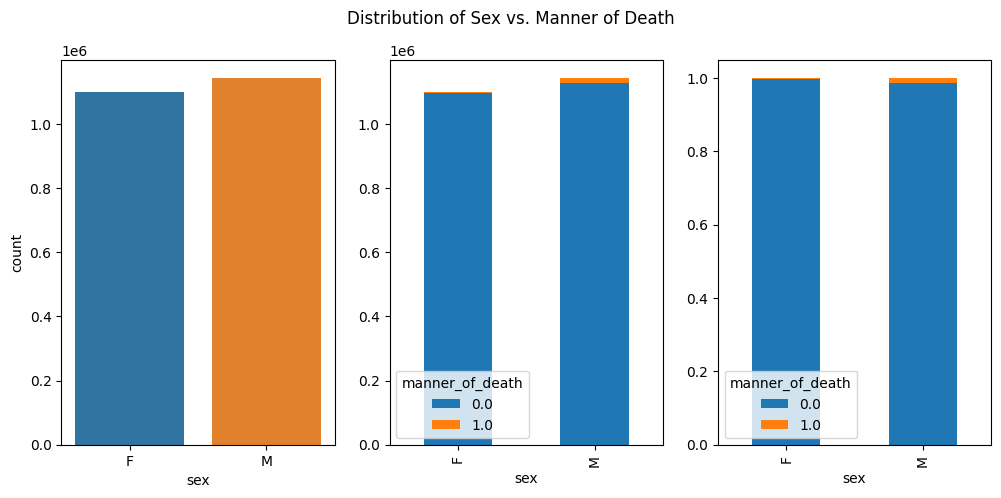

In [181]:
# Value Counts
sex_counts = new_death['sex'].value_counts()
print("sex Frequency:")
print(sex_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Sex vs. Manner of Death")

# Plot Counts
sns.countplot(x="sex", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_sex = pd.crosstab(new_death['sex'], new_death['manner_of_death'])
crosstab_sex.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_sex_norm = crosstab_sex.div(crosstab_sex.sum(axis=1), axis = 0)
crosstab_sex_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 3.2.4 place_of_death_and_decedents_status

place_of_death_and_decedents_status Frequency:
4    653279
1    644968
6    449004
5    197270
2    146801
7    137804
3     10867
9       991
Name: place_of_death_and_decedents_status, dtype: int64


[Text(0, 0, 'Hospital, Clinic or Medical Center'),
 Text(1, 0, 'Hospital, Clinic or Medical Center'),
 Text(2, 0, 'Hospital, Clinic or Medical Center'),
 Text(3, 0, 'Decedents Home'),
 Text(4, 0, 'Hospice Facility'),
 Text(5, 0, 'Nursing Home/Long Term Care'),
 Text(6, 0, 'Other'),
 Text(7, 0, 'Unknown')]

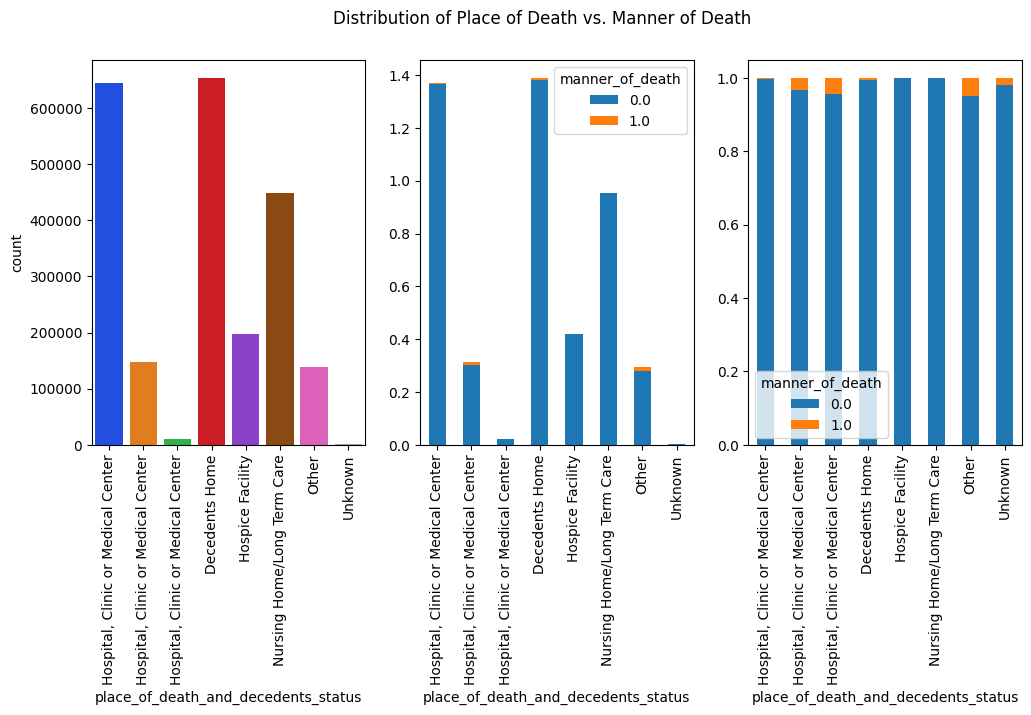

In [182]:
# Value Counts
place_of_death_and_decedents_status_counts = new_death['place_of_death_and_decedents_status'].value_counts()
print("place_of_death_and_decedents_status Frequency:")
print(place_of_death_and_decedents_status_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Place of Death vs. Manner of Death")

# Plot Counts
sns.countplot(x="place_of_death_and_decedents_status", data=new_death, ax=axs[0], palette = "bright")
labels = ["Hospital, Clinic or Medical Center", "Hospital, Clinic or Medical Center", "Hospital, Clinic or Medical Center", "Decedents Home", "Hospice Facility", "Nursing Home/Long Term Care", "Other", "Unknown"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_place_of_death_and_decedents_status = pd.crosstab(new_death['place_of_death_and_decedents_status'], new_death['manner_of_death']) / total
crosstab_place_of_death_and_decedents_status.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_place_of_death_and_decedents_status_norm = crosstab_place_of_death_and_decedents_status.div(crosstab_place_of_death_and_decedents_status.sum(axis=1), axis = 0)
crosstab_place_of_death_and_decedents_status_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.5 marital_status

marital_status Frequency:
M    830340
W    757912
D    352091
S    283985
U     16656
Name: marital_status, dtype: int64


[Text(0, 0, 'Divorced'),
 Text(1, 0, 'Married'),
 Text(2, 0, 'Single'),
 Text(3, 0, 'Unknown'),
 Text(4, 0, 'Widowed')]

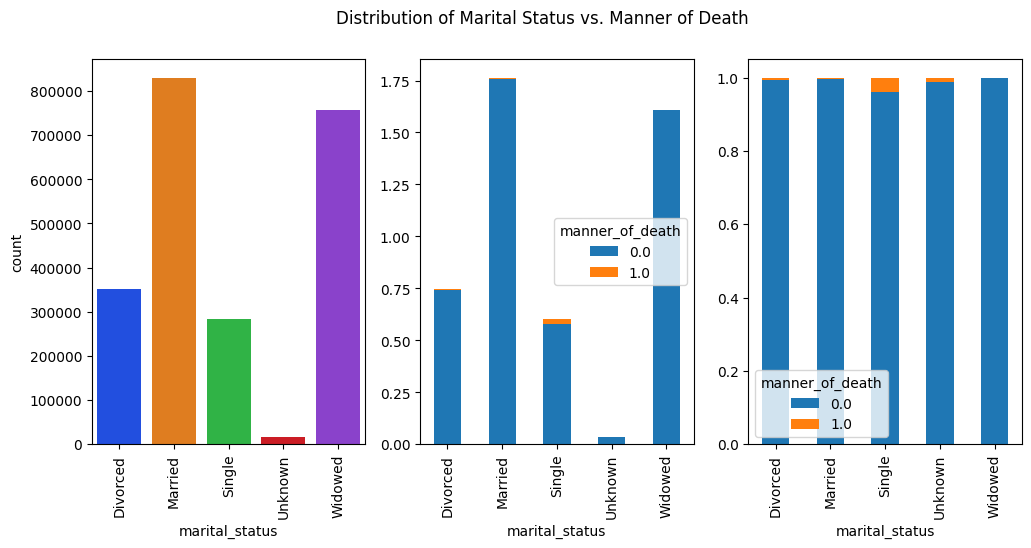

In [183]:
# Value Counts
marital_status_counts = new_death['marital_status'].value_counts()
print("marital_status Frequency:")
print(marital_status_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Marital Status vs. Manner of Death")

# Plot Counts
sns.countplot(x="marital_status", data=new_death, ax=axs[0], palette = "bright")
labels = ["Divorced", "Married", "Single", "Unknown", "Widowed"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_marital_status = pd.crosstab(new_death['marital_status'], new_death['manner_of_death']) / total
crosstab_marital_status.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_marital_status_norm = crosstab_marital_status.div(crosstab_marital_status.sum(axis=1), axis = 0)
crosstab_marital_status_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.6 day_of_week_of_death

day_of_week_of_death Frequency:
5    325029
7    321911
6    321268
2    319099
1    318702
3    317615
4    317223
9       137
Name: day_of_week_of_death, dtype: int64


[Text(0, 0, 'Sunday'),
 Text(1, 0, 'Monday'),
 Text(2, 0, 'Tuesday'),
 Text(3, 0, 'Wednesday'),
 Text(4, 0, 'Thursday'),
 Text(5, 0, 'Friday'),
 Text(6, 0, 'Saturday'),
 Text(7, 0, 'Unknown')]

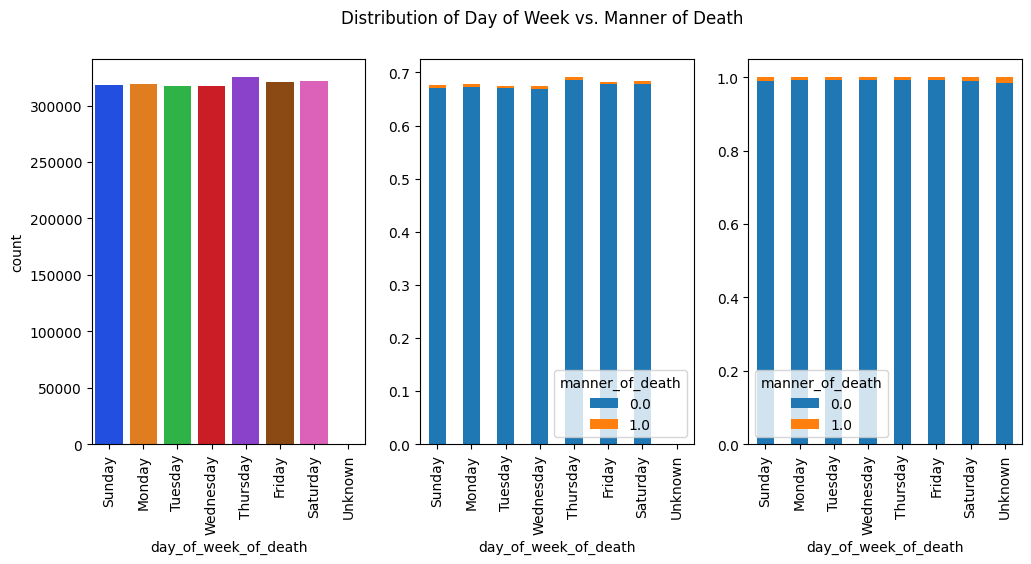

In [184]:
# Value Counts
day_of_week_of_death_counts = new_death['day_of_week_of_death'].value_counts()
print("day_of_week_of_death Frequency:")
print(day_of_week_of_death_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Day of Week vs. Manner of Death")

# Plot Counts
sns.countplot(x="day_of_week_of_death", data=new_death, ax=axs[0], palette = "bright")
labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Unknown"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_day_of_week_of_death = pd.crosstab(new_death['day_of_week_of_death'], new_death['manner_of_death']) / total
crosstab_day_of_week_of_death.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_day_of_week_of_death_norm = crosstab_day_of_week_of_death.div(crosstab_day_of_week_of_death.sum(axis=1), axis = 0)
crosstab_day_of_week_of_death_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.7 injury_at_work

injury_at_work Frequency:
U    2032906
N     203941
Y       4137
Name: injury_at_work, dtype: int64


[Text(0, 0, 'No'), Text(1, 0, 'Unknown'), Text(2, 0, 'Yes')]

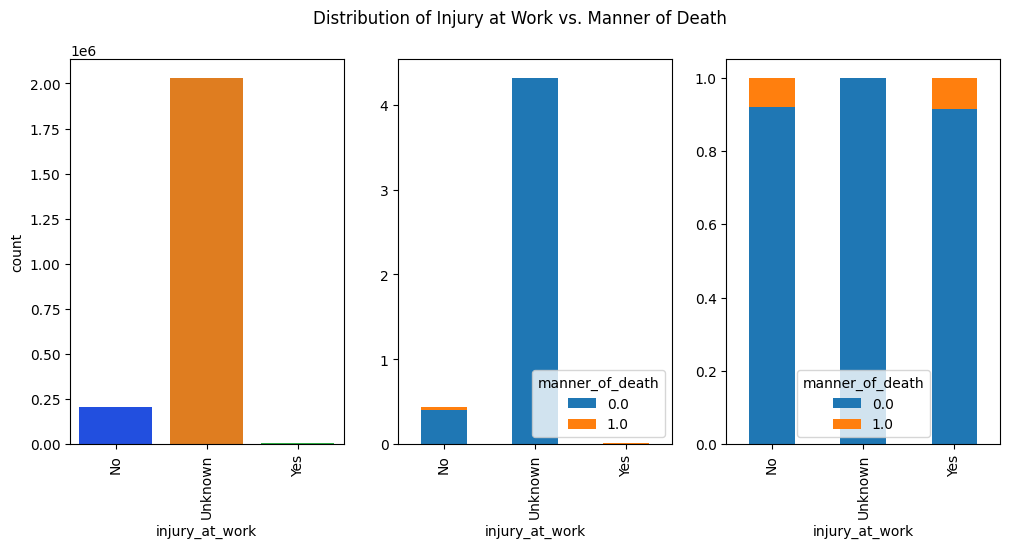

In [185]:
# Value Counts
injury_at_work_counts = new_death['injury_at_work'].value_counts()
print("injury_at_work Frequency:")
print(injury_at_work_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Injury at Work vs. Manner of Death")

# Plot Counts
sns.countplot(x="injury_at_work", data=new_death, ax=axs[0], palette = "bright")
labels = ["No", "Unknown", "Yes"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_injury_at_work = pd.crosstab(new_death['injury_at_work'], new_death['manner_of_death']) / total
crosstab_injury_at_work.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_injury_at_work_norm = crosstab_injury_at_work.div(crosstab_injury_at_work.sum(axis=1), axis = 0)
crosstab_injury_at_work_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.8 method_of_disposition

method_of_disposition Frequency:
C    1076649
B    1026519
R      64524
E      38376
D      23082
O      11034
U        800
Name: method_of_disposition, dtype: int64


[Text(0, 0, 'Burial'),
 Text(1, 0, 'Cremation'),
 Text(2, 0, 'D'),
 Text(3, 0, 'E'),
 Text(4, 0, 'Other'),
 Text(5, 0, 'R'),
 Text(6, 0, 'Unknown')]

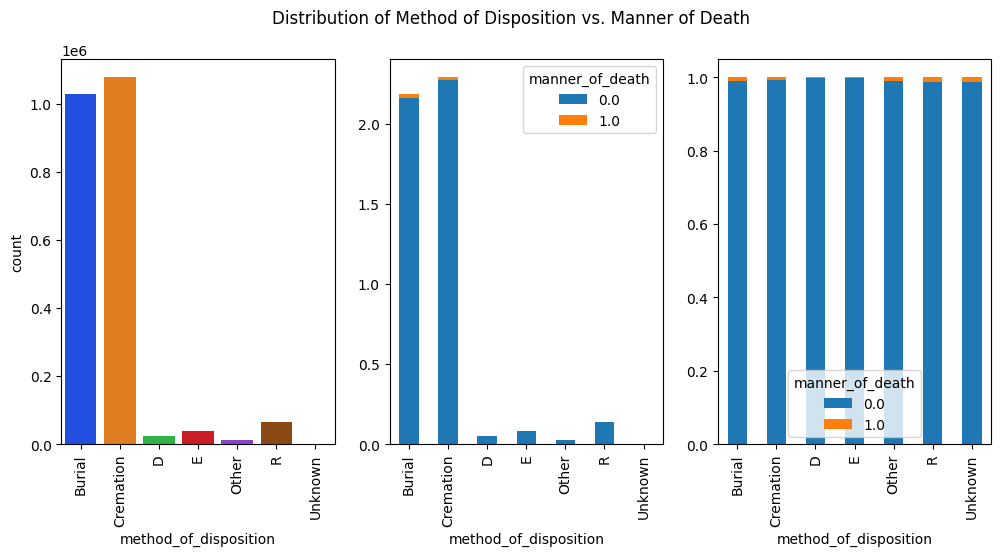

In [186]:
# Value Counts
method_of_disposition_counts = new_death['method_of_disposition'].value_counts()
print("method_of_disposition Frequency:")
print(method_of_disposition_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Method of Disposition vs. Manner of Death")

# Plot Counts
sns.countplot(x="method_of_disposition", data=new_death, ax=axs[0], palette = "bright")
labels = ["Burial", "Cremation", "D", "E", "Other", "R", "Unknown"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_method_of_disposition = pd.crosstab(new_death['method_of_disposition'], new_death['manner_of_death']) / total
crosstab_method_of_disposition.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_method_of_disposition_norm = crosstab_method_of_disposition.div(crosstab_method_of_disposition.sum(axis=1), axis = 0)
crosstab_method_of_disposition_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.9 autopsy

autopsy Frequency:
N    1907983
Y     191837
U     141164
Name: autopsy, dtype: int64


[Text(0, 0, 'No'), Text(1, 0, 'Unknown'), Text(2, 0, 'Yes')]

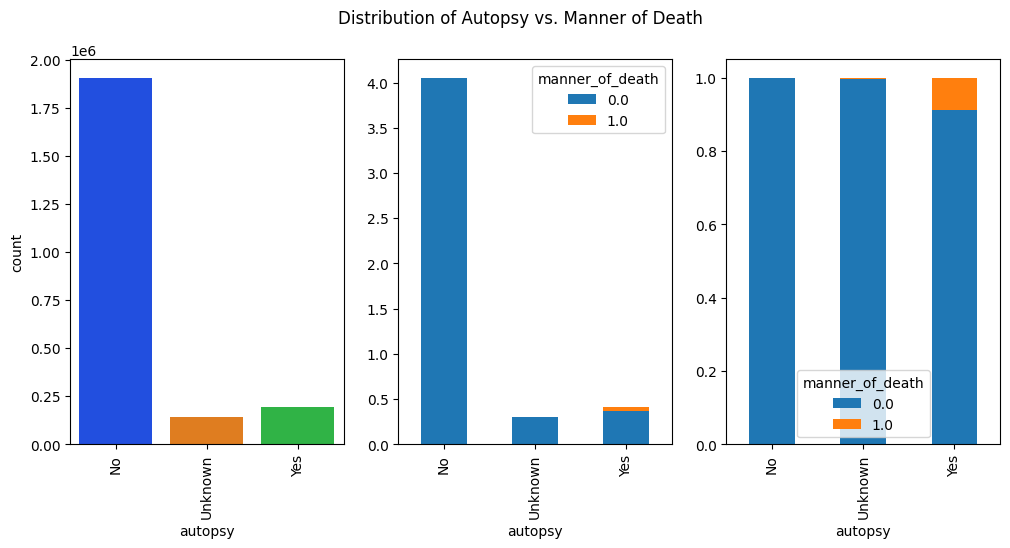

In [187]:
# Value Counts
autopsy_counts = new_death['autopsy'].value_counts()
print("autopsy Frequency:")
print(autopsy_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Autopsy vs. Manner of Death")

# Plot Counts
sns.countplot(x="autopsy", data=new_death, ax=axs[0], palette = "bright")
labels = ["No", "Unknown", "Yes"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_autopsy = pd.crosstab(new_death['autopsy'], new_death['manner_of_death']) / total
crosstab_autopsy.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay and Normalization
crosstab_autopsy_norm = crosstab_autopsy.div(crosstab_autopsy.sum(axis=1), axis = 0)
crosstab_autopsy_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.10 race

race Frequency:
1     1925966
2      257544
3       16697
4        7548
18       6130
7        5958
5        5522
68       5378
28       3183
48       3087
78       2602
6         640
38        448
58        281
Name: race, dtype: int64


[Text(0, 0, 'White'),
 Text(1, 0, 'Black'),
 Text(2, 0, 'American Indian'),
 Text(3, 0, 'Chinese'),
 Text(4, 0, 'Japanese'),
 Text(5, 0, 'Hawaiian'),
 Text(6, 0, 'Filipino'),
 Text(7, 0, 'Asian Indian'),
 Text(8, 0, 'Korean'),
 Text(9, 0, 'Samoan'),
 Text(10, 0, 'Vietnamese'),
 Text(11, 0, 'Guamanian'),
 Text(12, 0, 'Other Asian or Pacific Islander'),
 Text(13, 0, 'Combined other Asian or Pacific Islander')]

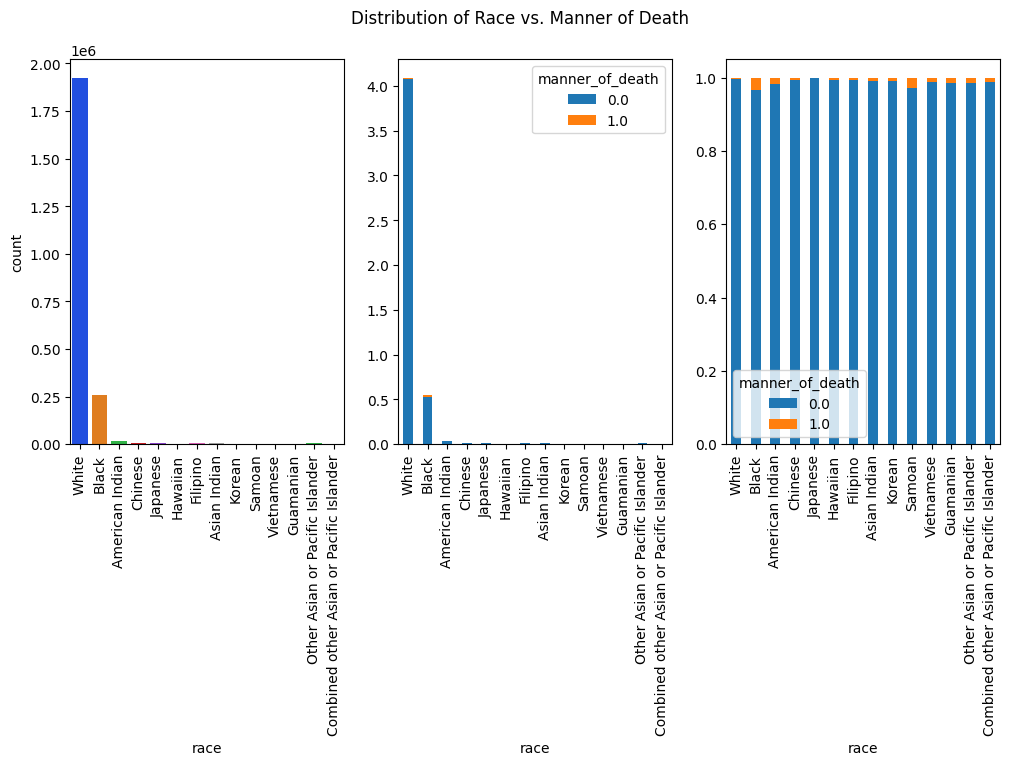

In [188]:
# Value Counts
race_counts = new_death['race'].value_counts()
print("race Frequency:")
print(race_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Race vs. Manner of Death")

# Plot Counts
sns.countplot(x="race", data=new_death, ax=axs[0], palette = "bright")
labels = ["White", "Black", "American Indian", "Chinese", "Japanese", "Hawaiian", "Filipino", "Asian Indian",
          "Korean", "Samoan", "Vietnamese", "Guamanian", "Other Asian or Pacific Islander", "Combined other Asian or Pacific Islander"]
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=90)

# Plot Counts with Overlay
crosstab_race = pd.crosstab(new_death['race'], new_death['manner_of_death']) / total
crosstab_race.plot(kind='bar', ax=axs[1], stacked = True)
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

crosstab_race_norm = crosstab_race.div(crosstab_race.sum(axis=1), axis = 0)
crosstab_race_norm.plot(kind='bar', ax=axs[2], stacked = True)
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=90)

##### 3.2.11 manner_of_death

manner_of_death Frequency:
0.0    2310949
1.0      18885
Name: manner_of_death, dtype: int64


([<matplotlib.axis.XTick at 0x78ac441b0070>,
 [Text(0, 0, 'Not Homicide'), Text(1, 0, 'Homicide')])

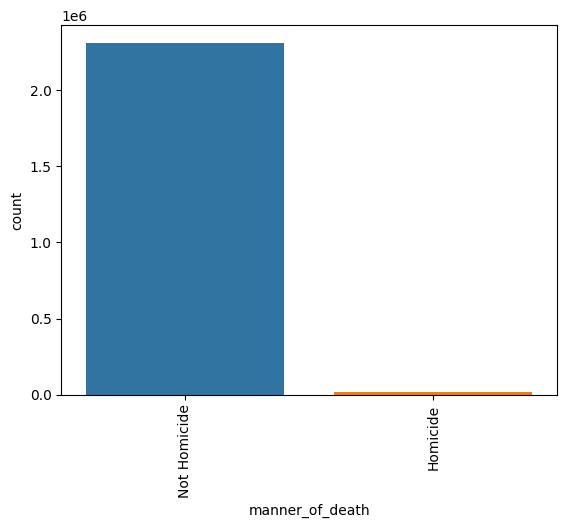

In [69]:
# Value Counts
manner_of_death_counts = new_death['manner_of_death'].value_counts()
print("manner_of_death Frequency:")
print(manner_of_death_counts)

# Plot Counts
sns.countplot(x="manner_of_death", data=new_death)
labels = ["Not Homicide", "Homicide"]
plt.xticks(range(len(labels)), labels, rotation=90)

#### 3.3 Numerical Data Analysis

3.3.1 detail_age

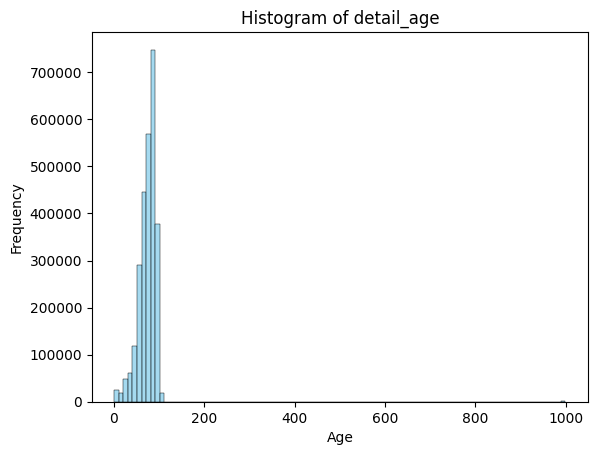

In [70]:
detail_age = new_death['detail_age']
sns.histplot(detail_age, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of detail_age')
plt.show()

There are outliers that are causing a non-representative view of the age distribution. We will remove the outliers.

In [71]:
# Compute z-score for every data point in detail_age
new_death['z_detail_age'] = (new_death['detail_age']-new_death['detail_age'].mean())/new_death['detail_age'].std()
print('Number of rows before discarding outliers = %d' % (new_death.shape[0]))

# Removes rows with a zscore beyond 3 or -3
new_death = new_death[(new_death['z_detail_age'] <= 3) & (new_death['z_detail_age'] >= -3)]
print('Number of rows after discarding missing values = %d' % (new_death.shape[0]))

# Drop the 'C' column
column_name = 'z_detail_age'
new_death.drop(column_name, axis=1, inplace=True)

Number of rows before discarding outliers = 2718198
Number of rows after discarding missing values = 2696935


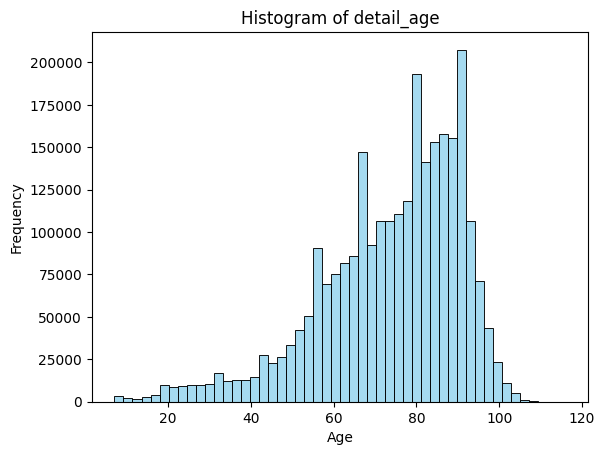

In [72]:
# Plot a Histogram for detail_age
detail_age = new_death['detail_age']
sns.histplot(detail_age, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of detail_age')
plt.show()

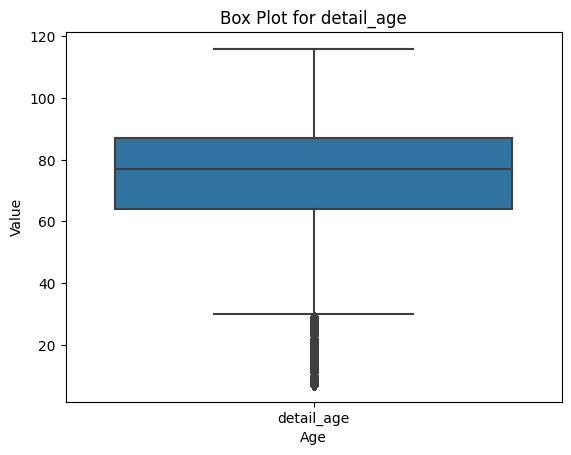

In [73]:
# Plot a Box Plot for detail_age
sns.boxplot(data=new_death[['detail_age']])
plt.xlabel('Age')
plt.ylabel('Value')
plt.title("Box Plot for detail_age")
plt.show()

<Axes: xlabel='detail_age', ylabel='manner_of_death'>

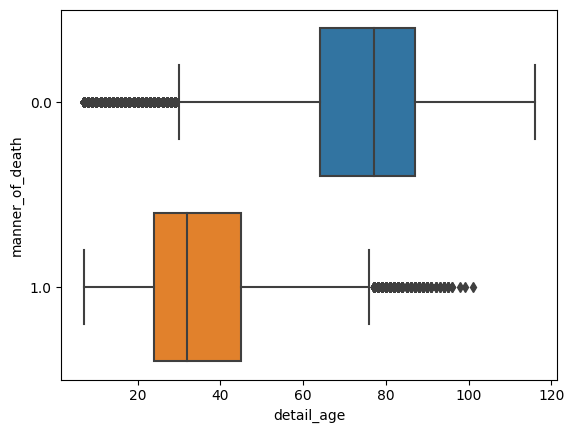

In [74]:
# Plot a Box Plot for detail_age grouped by manner_of_death
sns.boxplot(x="detail_age", y="manner_of_death", data=new_death)

#### 3.4 Correlation Analysis

In [75]:
new_death = new_death.dropna()

3.4.1 education_2003_revision and manner_of_death

In [76]:
# Create a cross-tabulation (crosstab) between education_2003_revision and manner_of_death
education_2003_revision_manner_of_death_crosstab = pd.crosstab(new_death['education_2003_revision'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between education_2003_revision and manner_of_death: Original")
print(education_2003_revision_manner_of_death_crosstab)

Cross-Tabulation between education_2003_revision and manner_of_death: Original
manner_of_death             0.0   1.0
education_2003_revision              
1.0                      222519  1223
2.0                      237275  4433
3.0                      932296  7827
4.0                      257849  2181
5.0                      133534   670
6.0                      216864   640
7.0                       86068   185
8.0                       34131    71
9.0                      102785   433


In [77]:
# Perform the chi-square test - education_2003_revision and manner_of_death
chi2, p, dof, expected_edu = chi2_contingency(education_2003_revision_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_edu)

Chi-Square Value: 5091.882994132267
P-value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[2.21978509e+05 1.76349092e+03]
 [2.39802905e+05 1.90509544e+03]
 [9.32713133e+05 7.40986663e+03]
 [2.57980494e+05 2.04950588e+03]
 [1.33146230e+05 1.05776982e+03]
 [2.15789676e+05 1.71432422e+03]
 [8.55731706e+04 6.79829369e+02]
 [3.39324265e+04 2.69573511e+02]
 [1.02404456e+05 8.13544199e+02]]


3.4.2 month_of_death and manner_of_death

In [78]:
# Create a cross-tabulation (crosstab) between month_of_death and manner_of_death
month_of_death_manner_of_death_crosstab = pd.crosstab(new_death['month_of_death'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between month_of_death and manner_of_death: Original")
print(month_of_death_manner_of_death_crosstab)

Cross-Tabulation between month_of_death and manner_of_death: Original
manner_of_death     0.0   1.0
month_of_death               
1                219106  1415
2                187000  1086
3                200356  1345
4                185049  1290
5                184542  1496
6                173860  1528
7                179049  1670
8                176715  1687
9                172365  1603
10               182441  1498
11               177127  1485
12               185711  1560


In [79]:
# Perform the chi-square test - month_of_death and manner_of_death
chi2, p, dof, expected_month = chi2_contingency(month_of_death_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_month)

Chi-Square Value: 392.813712101934
P-value: 2.0509165380548442e-77
Degrees of Freedom: 11
Expected Frequencies:
[[218782.89637097   1738.10362903]
 [186603.54273212   1482.45726788]
 [200111.23195034   1589.76804966]
 [184870.31224632   1468.68775368]
 [184571.68466977   1466.31533023]
 [174005.62589827   1382.37410173]
 [179294.60799319   1424.39200681]
 [176995.87013651   1406.12986349]
 [172596.81806207   1371.18193793]
 [182489.2285795    1449.7714205 ]
 [177204.21495736   1407.78504264]
 [185794.9664036    1476.0335964 ]]


3.4.3 sex and manner_of_death

In [80]:
# Create a cross-tabulation (crosstab) between sex and manner_of_death
sex_manner_of_death_crosstab = pd.crosstab(new_death['sex'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between sex and manner_of_death:")
print(sex_manner_of_death_crosstab)

Cross-Tabulation between sex and manner_of_death:
manner_of_death      0.0    1.0
sex                            
F                1095170   3324
M                1128151  14339


In [81]:
# Perform the chi-square test - sex and manner_of_death
chi2, p, dof, expected_sex = chi2_contingency(sex_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_sex)

Chi-Square Value: 6495.955313178413
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[1089835.88395723    8658.11604277]
 [1133485.11604277    9004.88395723]]


3.4.4 place_of_death_and_decedents_status and manner_of_death

In [82]:
# Create a cross-tabulation (crosstab) between place_of_death_and_decedents_status and manner_of_death
place_of_death_and_decedents_status_manner_of_death_crosstab = pd.crosstab(new_death['place_of_death_and_decedents_status'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between place_of_death_and_decedents_status and manner_of_death: Original")
print(place_of_death_and_decedents_status_manner_of_death_crosstab)

Cross-Tabulation between place_of_death_and_decedents_status and manner_of_death: Original
manner_of_death                         0.0   1.0
place_of_death_and_decedents_status              
1                                    642690  2278
2                                    142214  4587
3                                     10394   473
4                                    649767  3512
5                                    197206    64
6                                    448910    94
7                                    131168  6636
9                                       972    19


In [83]:
# Perform the chi-square test - place_of_death_and_decedents_status and manner_of_death
chi2, p, dof, expected_place = chi2_contingency(place_of_death_and_decedents_status_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_place)

Chi-Square Value: 47519.6446655629
P-value: 0.0
Degrees of Freedom: 7
Expected Frequencies:
[[6.39884488e+05 5.08351232e+03]
 [1.45643943e+05 1.15705693e+03]
 [1.07813484e+04 8.56515803e+01]
 [6.48129982e+05 5.14901801e+03]
 [1.95715156e+05 1.55484377e+03]
 [4.45465038e+05 3.53896219e+03]
 [1.36717856e+05 1.08614432e+03]
 [9.83189131e+02 7.81086924e+00]]


3.4.5 marital_status and manner_of_death

In [84]:
# Create a cross-tabulation (crosstab) between marital_status and manner_of_death
marital_status_manner_of_death_crosstab = pd.crosstab(new_death['marital_status'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between marital_status and manner_of_death: Original")
print(marital_status_manner_of_death_crosstab)

Cross-Tabulation between marital_status and manner_of_death: Original
manner_of_death     0.0    1.0
marital_status                
D                349989   2102
M                827022   3318
S                272482  11503
U                 16455    201
W                757373    539


In [85]:
# Perform the chi-square test - marital_status and manner_of_death
chi2, p, dof, expected_marital = chi2_contingency(marital_status_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_marital)

Chi-Square Value: 45441.335983314224
P-value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[3.49315887e+05 2.77511278e+03]
 [8.23795422e+05 6.54457837e+03]
 [2.81746685e+05 2.23831453e+03]
 [1.65247206e+04 1.31279352e+02]
 [7.51938285e+05 5.97371496e+03]]


3.4.6 day_of_week_of_death and manner_of_death

In [86]:
# Create a cross-tabulation (crosstab) between day_of_week_of_death and manner_of_death
day_of_week_of_death_manner_of_death_crosstab = pd.crosstab(new_death['day_of_week_of_death'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between day_of_week_of_death and manner_of_death: Original")
print(day_of_week_of_death_manner_of_death_crosstab)

Cross-Tabulation between day_of_week_of_death and manner_of_death: Original
manner_of_death          0.0   1.0
day_of_week_of_death              
1                     315651  3051
2                     316748  2351
3                     315284  2331
4                     314853  2370
5                     322649  2380
6                     318955  2313
7                     319046  2865
9                        135     2


In [87]:
# Perform the chi-square test - day_of_week_of_death and manner_of_death
chi2, p, dof, expected_day = chi2_contingency(day_of_week_of_death_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_day)

Chi-Square Value: 221.78779505400476
P-value: 2.7535771533177317e-44
Degrees of Freedom: 7
Expected Frequencies:
[[3.16190053e+05 2.51194717e+03]
 [3.16583924e+05 2.51507625e+03]
 [3.15111620e+05 2.50337965e+03]
 [3.14722710e+05 2.50028998e+03]
 [3.22467185e+05 2.56181536e+03]
 [3.18735828e+05 2.53217189e+03]
 [3.19373760e+05 2.53723989e+03]
 [1.35920193e+02 1.07980735e+00]]


3.4.7 injury_at_work and manner_of_death

In [88]:
# Create a cross-tabulation (crosstab) between injury_at_work and manner_of_death
injury_at_work_manner_of_death_crosstab = pd.crosstab(new_death['injury_at_work'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between injury_at_work and manner_of_death: Original")
print(injury_at_work_manner_of_death_crosstab)

Cross-Tabulation between injury_at_work and manner_of_death: Original
manner_of_death      0.0    1.0
injury_at_work                 
N                 187674  16267
U                2031861   1045
Y                   3786    351


In [89]:
# Perform the chi-square test - injury_at_work and manner_of_death
chi2, p, dof, expected_injury = chi2_contingency(injury_at_work_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_injury)

Chi-Square Value: 152002.35157940557
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[2.02333577e+05 1.60742329e+03]
 [2.01688303e+06 1.60229697e+04]
 [4.10439297e+03 3.26070293e+01]]


3.4.8 method_of_disposition and manner_of_death

In [90]:
# Create a cross-tabulation (crosstab) between method_of_disposition and manner_of_death
method_of_disposition_manner_of_death_crosstab = pd.crosstab(new_death['method_of_disposition'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between method_of_disposition and manner_of_death: Original")
print(method_of_disposition_manner_of_death_crosstab)

Cross-Tabulation between method_of_disposition and manner_of_death: Original
manner_of_death            0.0    1.0
method_of_disposition                
B                      1016484  10035
C                      1069990   6659
D                        23067     15
E                        38293     83
O                        10940     94
R                        63756    768
U                          791      9


In [91]:
# Perform the chi-square test - method_of_disposition and manner_of_death
chi2, p, dof, expected_method = chi2_contingency(method_of_disposition_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_method)

Chi-Square Value: 1317.356592171596
P-value: 1.8935904481410768e-281
Degrees of Freedom: 6
Expected Frequencies:
[[1.01842818e+06 8.09082309e+03]
 [1.06816306e+06 8.48593800e+03]
 [2.29000722e+04 1.81927834e+02]
 [3.80735278e+04 3.02472168e+02]
 [1.09470322e+04 8.69678418e+01]
 [6.40154344e+04 5.08565618e+02]
 [7.93694556e+02 6.30544439e+00]]


3.4.9 autopsy and manner_of_death

In [92]:
# Create a cross-tabulation (crosstab) between autopsy and manner_of_death
autopsy_manner_of_death_crosstab = pd.crosstab(new_death['autopsy'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between autopsy and manner_of_death: Original")
print(autopsy_manner_of_death_crosstab)

Cross-Tabulation between autopsy and manner_of_death: Original
manner_of_death      0.0    1.0
autopsy                        
N                1907687    296
U                 140648    516
Y                 174986  16851


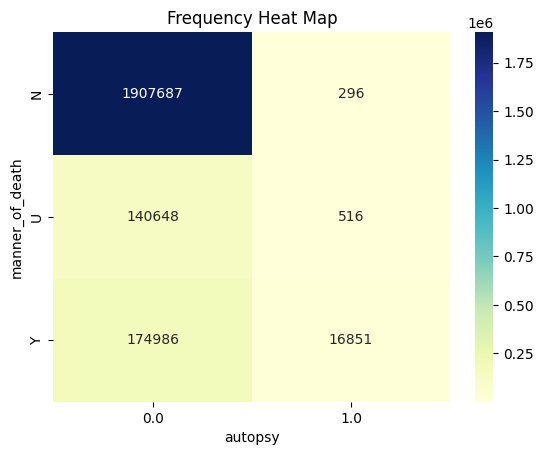

In [93]:
# Create a heat map
sns.heatmap(autopsy_manner_of_death_crosstab, annot=True, cmap='YlGnBu', fmt='d')

plt.title("Frequency Heat Map")
plt.xlabel("autopsy")
plt.ylabel("manner_of_death")

plt.show()

In [94]:
# Perform the chi-square test - autopsy and manner_of_death
chi2, p, dof, expected_autopsy = chi2_contingency(autopsy_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_autopsy)

Chi-Square Value: 171734.7072205592
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[1.89294465e+06 1.50383509e+04]
 [1.40051373e+05 1.11262719e+03]
 [1.90324978e+05 1.51202192e+03]]


3.4.10 race and manner_of_death

In [95]:
# Create a cross-tabulation (crosstab) between race and manner_of_death
race_manner_of_death_crosstab = pd.crosstab(new_death['race'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between race and manner_of_death: Original")
print(race_manner_of_death_crosstab)


Cross-Tabulation between race and manner_of_death: Original
manner_of_death      0.0   1.0
race                          
1                1917780  8186
2                 248705  8839
3                  16407   290
4                   7502    46
5                   5510    12
6                    635     5
7                   5926    32
18                  6074    56
28                  3153    30
38                   435    13
48                  3048    39
58                   277     4
68                  5295    83
78                  2574    28


In [96]:
# Perform the chi-square test - race and manner_of_death
chi2, p, dof, expected_race = chi2_contingency(race_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_race)

Chi-Square Value: 26572.963414887086
P-value: 0.0
Degrees of Freedom: 13
Expected Frequencies:
[[1.91078591e+06 1.51800894e+04]
 [2.55514088e+05 2.02991171e+03]
 [1.65653975e+04 1.31602506e+02]
 [7.48850813e+03 5.94918679e+01]
 [5.47847667e+03 4.35233299e+01]
 [6.34955644e+02 5.04435552e+00]
 [5.91104020e+03 4.69597971e+01]
 [6.08168453e+03 4.83154677e+01]
 [3.15791221e+03 2.50877869e+01]
 [4.44468951e+02 3.53104886e+00]
 [3.06266887e+03 2.43311336e+01]
 [2.78785213e+02 2.21478734e+00]
 [5.33561165e+03 4.23883499e+01]
 [2.58149154e+03 2.05084579e+01]]


## 4. Data Preprocessing

#### 4.1 Drop Missing Data

In [97]:
# Drop rows with missing values
death_dropped = new_death.dropna()

In [98]:
# Check Missing Values were Dropped
total_missing_values3 = death_dropped.isnull().sum().sum()
total_elements3 = death_dropped.size
total_percent_missing3 = (total_missing_values3 / total_elements3) * 100
print("Total percentage of missing data in the sample dataset: {:.2f}%".format(total_percent_missing3))

Total percentage of missing data in the sample dataset: 0.00%


#### 4.2 Random Sample

In [99]:
# Perform random sampling
sampled_df = death_dropped.sample(frac=0.3, random_state=1)
print('Number of rows after random sampling = %d' % (sampled_df.shape[0]))

Number of rows after random sampling = 672295


#### 4.3 Normalize Data and Encode Categorical Variables

In [100]:
# Normalize detail_age using Min-Max scaler
mms = MinMaxScaler()
sampled_df[['detail_age']] = mms.fit_transform(sampled_df[['detail_age']])

In [101]:
# Perform one-hot encoding on categorical columns
encoded_df = pd.get_dummies(sampled_df, columns=['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work','method_of_disposition', 'autopsy', 'race'],
                            prefix=['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work','method_of_disposition', 'autopsy', 'race'])

#### 4.4 Class Imbalances

In [102]:
# Calculate class proportions
class_proportions = encoded_df['manner_of_death'].value_counts(normalize=True)

print(class_proportions)

0.0    0.992131
1.0    0.007869
Name: manner_of_death, dtype: float64


In [103]:
# Split data for rebalancing
train, test = train_test_split(encoded_df, test_size=0.3, random_state=42)

In [104]:
# Identify current proportion of homicide records
total = train.shape[0]
print('\nTotal number of instances in train sample: ', total)

homicide = train['manner_of_death'].value_counts()[1]
print('\nTotal number of homicide instances in train sample: ', homicide)

# Calculate number to resample
x = ((0.2 * total) - homicide) / 0.8
print('\nNumber of homicide records to resample: ', int(x))

# Resample data to increase number of homicide records
to_resample = train.loc[train['manner_of_death'] == 1]
our_resample = to_resample.sample(n = int(x), replace = True)
encoded_df_rebal = pd.concat([train, our_resample])
encoded_df_rebal['manner_of_death'].value_counts()

# Check percentage is met
ratio = encoded_df_rebal['manner_of_death'].value_counts()[1] / encoded_df_rebal.shape[0] * 100
print('\nNew percent of homicide records: ', round(ratio, 0))


Total number of instances in train sample:  470606

Total number of homicide instances in train sample:  3746

Number of homicide records to resample:  112969

New percent of homicide records:  20.0


#### 4.5 Validation Data Set

In [105]:
# Subset data from death_data where manner_of_death is undetermined
validation_data = death_data[death_data['manner_of_death'] == 5]

# Isolate the Desired Columns
desired_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'method_of_disposition',
                   'autopsy', 'race','detail_age']
validation_data = validation_data[desired_columns]

# List of column names to convert to categorical
categorical_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'method_of_disposition', 'autopsy', 'race']

# Convert the selected columns to categorical
validation_data[categorical_columns] = validation_data[categorical_columns].astype('category')

# Drop rows with missing values
validation_data = validation_data.dropna()

## 5. Exploratory Data Analysis (Sampled Data Set)

#### 5.1 Categorical Correlation Analysis

##### 5.1.1 Cross Tabulation and Chi-Squared Test

In [129]:
sampled_df = sampled_df.dropna()
# print(sampled_df)

education_2003_revision and manner_of_death

In [130]:
# Create a cross-tabulation (crosstab) between education_2003_revision and manner_of_death
education_2003_revision_manner_of_death_crosstab2 = pd.crosstab(sampled_df['education_2003_revision'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between education_2003_revision and manner_of_death: Sampled")
print(education_2003_revision_manner_of_death_crosstab2)

Cross-Tabulation between education_2003_revision and manner_of_death: Sampled
manner_of_death             0.0   1.0
education_2003_revision              
1.0                       66845   365
2.0                       71120  1299
3.0                      279220  2365
4.0                       77639   652
5.0                       40056   184
6.0                       65016   204
7.0                       25987    55
8.0                       10221    24
9.0                       30901   142


In [131]:
# Perform the chi-square test - education_2003_revision and manner_of_death
chi2, p, dof, expected_edu2 = chi2_contingency(education_2003_revision_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_edu2)

Chi-Square Value: 1441.4037830286975
P-value: 6.3105934461569e-306
Degrees of Freedom: 8
Expected Frequencies:
[[6.66811534e+04 5.28846563e+02]
 [7.18491661e+04 5.69833942e+02]
 [2.79369329e+05 2.21567117e+03]
 [7.76749618e+04 6.16038183e+02]
 [3.99233688e+04 3.16631241e+02]
 [6.47068119e+04 5.13188109e+02]
 [2.58370867e+04 2.04913290e+02]
 [1.01643865e+04 8.06134956e+01]
 [3.07987360e+04 2.44264006e+02]]


month_of_death and manner_of_death

In [132]:
# Create a cross-tabulation (crosstab) between month_of_death and manner_of_death
month_of_death_manner_of_death_crosstab2 = pd.crosstab(sampled_df['month_of_death'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between month_of_death and manner_of_death: Sampled")
print(month_of_death_manner_of_death_crosstab2)

Cross-Tabulation between month_of_death and manner_of_death: Sampled
manner_of_death    0.0  1.0
month_of_death             
1                65674  433
2                56595  342
3                59772  407
4                55947  414
5                55236  449
6                52152  466
7                53550  488
8                53017  472
9                51740  459
10               54541  462
11               53112  439
12               55669  459


In [133]:
# Perform the chi-square test - month_of_death and manner_of_death
chi2, p, dof, expected_month2 = chi2_contingency(month_of_death_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_month2)

Chi-Square Value: 82.98883049896384
P-value: 3.888729967637987e-13
Degrees of Freedom: 11
Expected Frequencies:
[[65586.83246938   520.16753062]
 [56488.98725262   448.01274738]
 [59705.47734997   473.52265003]
 [55917.51954871   443.48045129]
 [55246.83870176   438.16129824]
 [52203.97160473   414.02839527]
 [53612.79823589   425.20176411]
 [53068.1180806    420.8819194 ]
 [51788.26853539   410.73146461]
 [54570.20506623   432.79493377]
 [53129.63022929   421.36977071]
 [55686.35292543   441.64707457]]


sex and manner_of_death




In [134]:
# Create a cross-tabulation (crosstab) between sex and manner_of_death
sex_manner_of_death_crosstab2 = pd.crosstab(sampled_df['sex'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between sex and manner_of_death:")
print(sex_manner_of_death_crosstab2)

Cross-Tabulation between sex and manner_of_death:
manner_of_death     0.0   1.0
sex                          
F                328451  1008
M                338554  4282


In [135]:
# Perform the chi-square test - sex and manner_of_death
chi2, p, dof, expected2 = chi2_contingency(sex_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected2)

Chi-Square Value: 1912.6994855881999
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[326866.62892778   2592.37107222]
 [340138.37107222   2697.62892778]]


place_of_death_and_decedents_status and manner_of_death

In [136]:
# Create a cross-tabulation (crosstab) between place_of_death_and_decedents_status and manner_of_death
place_of_death_and_decedents_status_manner_of_death_crosstab2 = pd.crosstab(sampled_df['place_of_death_and_decedents_status'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between place_of_death_and_decedents_status and manner_of_death: Sampled")
print(place_of_death_and_decedents_status_manner_of_death_crosstab2)

Cross-Tabulation between place_of_death_and_decedents_status and manner_of_death: Sampled
manner_of_death                         0.0   1.0
place_of_death_and_decedents_status              
1                                    192951   677
2                                     42741  1345
3                                      3147   138
4                                    194959  1106
5                                     59126    14
6                                    134678    33
7                                     39126  1968
9                                       277     9


In [137]:
# Perform the chi-square test - place_of_death_and_decedents_status and manner_of_death
chi2, p, dof, expected_place2 = chi2_contingency(place_of_death_and_decedents_status_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_place2)

Chi-Square Value: 13879.830818198803
P-value: 0.0
Degrees of Freedom: 7
Expected Frequencies:
[[1.92104425e+05 1.52357539e+03]
 [4.37391062e+04 3.46893759e+02]
 [3.25915175e+03 2.58482511e+01]
 [1.94522249e+05 1.54275110e+03]
 [5.86746528e+04 4.65347206e+02]
 [1.33651017e+05 1.05998288e+03]
 [4.07706490e+04 3.23350999e+02]
 [2.83749589e+02 2.25041091e+00]]


marital_status and manner_of_death

In [138]:
# Create a cross-tabulation (crosstab) between marital_status and manner_of_death
marital_status_manner_of_death_crosstab2 = pd.crosstab(sampled_df['marital_status'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between marital_status and manner_of_death: Sampled")
print(marital_status_manner_of_death_crosstab2)

Cross-Tabulation between marital_status and manner_of_death: Sampled
manner_of_death     0.0   1.0
marital_status               
D                105006   678
M                247983   976
S                 81791  3410
U                  4920    64
W                227305   162


In [139]:
# Perform the chi-square test - marital_status and manner_of_death
chi2, p, dof, expected_marital2 = chi2_contingency(marital_status_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_marital2)

Chi-Square Value: 13317.70887813533
P-value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[1.04852418e+05 8.31581910e+02]
 [2.47000049e+05 1.95895122e+03]
 [8.45305900e+04 6.70409999e+02]
 [4.94478305e+03 3.92169509e+01]
 [2.25677160e+05 1.78983992e+03]]


day_of_week_of_death and manner_of_death

In [140]:
# Create a cross-tabulation (crosstab) between day_of_week_of_death and manner_of_death
day_of_week_of_death_manner_of_death_crosstab2 = pd.crosstab(sampled_df['day_of_week_of_death'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between day_of_week_of_death and manner_of_death: Sampled")
print(day_of_week_of_death_manner_of_death_crosstab2)

Cross-Tabulation between day_of_week_of_death and manner_of_death: Sampled
manner_of_death         0.0  1.0
day_of_week_of_death            
1                     94874  912
2                     94654  732
3                     94259  701
4                     94410  706
5                     96997  709
6                     95958  678
7                     95806  850
9                        47    2


In [141]:
# Perform the chi-square test - day_of_week_of_death and manner_of_death
chi2, p, dof, expected_day2 = chi2_contingency(day_of_week_of_death_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_day2)

Chi-Square Value: 70.38318926294873
P-value: 1.2361028372831185e-12
Degrees of Freedom: 7
Expected Frequencies:
[[9.50323012e+04 7.53698808e+02]
 [9.46354486e+04 7.50551380e+02]
 [9.42128006e+04 7.47199369e+02]
 [9.43675731e+04 7.48426866e+02]
 [9.69371935e+04 7.68806461e+02]
 [9.58756129e+04 7.60387092e+02]
 [9.58954555e+04 7.60544463e+02]
 [4.86144401e+01 3.85559910e-01]]


 injury_at_work and manner_of_death

In [142]:
# Create a cross-tabulation (crosstab) between injury_at_work and manner_of_death
injury_at_work_manner_of_death_crosstab2 = pd.crosstab(sampled_df['injury_at_work'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between injury_at_work and manner_of_death: Sampled")
print(injury_at_work_manner_of_death_crosstab2)

Cross-Tabulation between injury_at_work and manner_of_death: Sampled
manner_of_death     0.0   1.0
injury_at_work               
N                 56106  4926
U                609826   249
Y                  1073   115


In [143]:
# Perform the chi-square test - injury_at_work and manner_of_death
chi2, p, dof, expected_injury2 = chi2_contingency(injury_at_work_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_injury2)

Chi-Square Value: 47036.170919819924
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[6.05517655e+04 4.80234540e+02]
 [6.05274582e+05 4.80041760e+03]
 [1.17865214e+03 9.34786069e+00]]


method_of_disposition and manner_of_death

In [144]:
# Create a cross-tabulation (crosstab) between method_of_disposition and manner_of_death
method_of_disposition_manner_of_death_crosstab2 = pd.crosstab(sampled_df['method_of_disposition'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between method_of_disposition and manner_of_death: Sampled")
print(method_of_disposition_manner_of_death_crosstab2)

Cross-Tabulation between method_of_disposition and manner_of_death: Sampled
manner_of_death           0.0   1.0
method_of_disposition              
B                      305130  2957
C                      320652  2054
D                        6925     0
E                       11455    19
O                        3292    36
R                       19286   219
U                         265     5


In [145]:
# Perform the chi-square test - method_of_disposition and manner_of_death
chi2, p, dof, expected_method2 = chi2_contingency(method_of_disposition_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_method2)

Chi-Square Value: 358.9649365126828
P-value: 1.8348806383230484e-74
Degrees of Freedom: 6
Expected Frequencies:
[[3.05662796e+05 2.42420400e+03]
 [3.20166765e+05 2.53923462e+03]
 [6.87051016e+03 5.44898445e+01]
 [1.13837160e+04 9.02839676e+01]
 [3.30181340e+03 2.61865996e+01]
 [1.93515235e+04 1.53476450e+02]
 [2.67875486e+02 2.12451379e+00]]


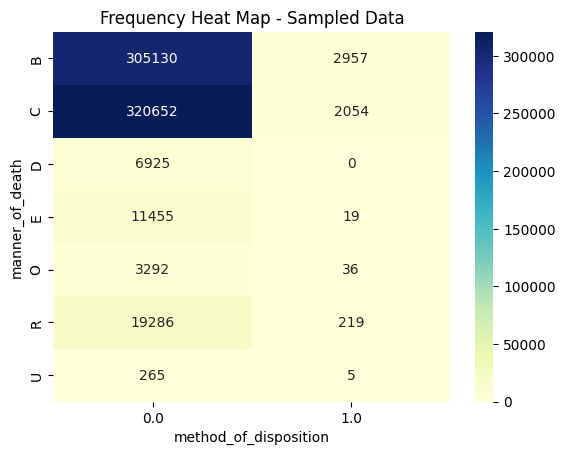

In [146]:
# Create a heat map
sns.heatmap(method_of_disposition_manner_of_death_crosstab2, annot=True, cmap='YlGnBu', fmt='d')

plt.title("Frequency Heat Map - Sampled Data")
plt.xlabel("method_of_disposition")
plt.ylabel("manner_of_death")

plt.show()

autopsy and manner_of_death

In [147]:
# Create a cross-tabulation (crosstab) between autopsy and manner_of_death
autopsy_manner_of_death_crosstab2 = pd.crosstab(sampled_df['autopsy'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between autopsy and manner_of_death: Sampled")
print(autopsy_manner_of_death_crosstab2)

Cross-Tabulation between autopsy and manner_of_death: Sampled
manner_of_death     0.0   1.0
autopsy                      
N                572217   103
U                 42469   118
Y                 52319  5069


In [148]:
# Perform the chi-square test - autopsy and manner_of_death
chi2, p, dof, expected_autopsy2 = chi2_contingency(autopsy_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_autopsy2)

Chi-Square Value: 52065.61200431707
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[5.67816660e+05 4.50333975e+03]
 [4.22519012e+04 3.35098774e+02]
 [5.69364385e+04 4.51561472e+02]]


race and manner_of_death

In [149]:
# Create a cross-tabulation (crosstab) between race and manner_of_death
race_manner_of_death_crosstab2 = pd.crosstab(sampled_df['race'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between race and manner_of_death: Sampled")
print(race_manner_of_death_crosstab2)

Cross-Tabulation between race and manner_of_death: Sampled
manner_of_death     0.0   1.0
race                         
1                575238  2510
2                 74581  2580
3                  5097    92
4                  2189    16
5                  1643     3
6                   181     3
7                  1795     7
18                 1826    19
28                  928     8
38                  148     4
48                  903    11
58                   76     1
68                 1633    31
78                  767     5


In [150]:
# Perform the chi-square test - race and manner_of_death
chi2, p, dof, expected_race2 = chi2_contingency(race_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_race2)

Chi-Square Value: 7493.5580912699825
P-value: 0.0
Degrees of Freedom: 13
Expected Frequencies:
[[5.73201950e+05 4.54605035e+03]
 [7.65538533e+04 6.07146699e+02]
 [5.14816999e+03 4.08300077e+01]
 [2.18764980e+03 1.73501960e+01]
 [1.63304833e+03 1.29516656e+01]
 [1.82552183e+02 1.44781681e+00]
 [1.78782084e+03 1.41791624e+01]
 [1.83048249e+03 1.45175109e+01]
 [9.28635019e+02 7.36498115e+00]
 [1.50803977e+02 1.19602258e+00]
 [9.06808127e+02 7.19187262e+00]
 [7.63941201e+01 6.05879859e-01]
 [1.65090670e+03 1.30932998e+01]
 [7.65925464e+02 6.07453573e+00]]


Multi Index Cross-Tabulation and Chi-Square

In [151]:
# Create a multivariate cross-tabulation (crosstab) between selected categorical variables
multi_index_crosstab = pd.crosstab(index=[sampled_df['education_2003_revision'], sampled_df['month_of_death'],
                                          sampled_df['sex'], sampled_df['place_of_death_and_decedents_status']],
                                   columns=sampled_df['manner_of_death'])

# Print the multi-index cross-tabulation
print("Multi-Index Cross-Tabulation:")
print(multi_index_crosstab)

Multi-Index Cross-Tabulation:
manner_of_death                                                                  0.0  \
education_2003_revision month_of_death sex place_of_death_and_decedents_status         
1.0                     1              F   1                                    1099   
                                           2                                     181   
                                           3                                      11   
                                           4                                     842   
                                           5                                     223   
...                                                                              ...   
9.0                     12             M   4                                     493   
                                           5                                     100   
                                           6                                     287   
  

In [152]:
# Perform the chi-square test - multi_index_crosstab2 - Sampled Data
chi2, p, dof, expected_EMSP = chi2_contingency(multi_index_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_EMSP)

Chi-Square Value: 29002.641325682347
P-value: 0.0
Degrees of Freedom: 1613
Expected Frequencies:
[[1.09134457e+03 8.65542656e+00]
 [1.80567920e+02 1.43207967e+00]
 [1.09134457e+01 8.65542656e-02]
 ...
 [2.84741721e+02 2.25827948e+00]
 [1.02189537e+02 8.10462669e-01]
 [1.98426286e+00 1.57371392e-02]]


In [153]:
# Create a multivariate cross-tabulation (crosstab) between selected categorical variables and 'manner_of_death'
multi_index_crosstab2 = pd.crosstab(index=[sampled_df['marital_status'], sampled_df['day_of_week_of_death'],
                                          sampled_df['injury_at_work'], sampled_df['method_of_disposition']],
                                   columns=sampled_df['manner_of_death'])

# Print the multi-index cross-tabulation
print("Multi-Index Cross-Tabulation:")
print(multi_index_crosstab2)

Multi-Index Cross-Tabulation:
manner_of_death                                                            0.0  \
marital_status day_of_week_of_death injury_at_work method_of_disposition         
D              1                    N              B                       444   
                                                   C                      1147   
                                                   D                        12   
                                                   E                         4   
                                                   O                         5   
...                                                                        ...   
W              9                    N              C                         1   
                                    U              B                         2   
                                                   C                         4   
                                                   O                

In [154]:
# Perform the chi-square test - multi_index_crosstab2
chi2, p, dof, expected_MDIM = chi2_contingency(multi_index_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_MDIM)

Chi-Square Value: 84501.93254507871
P-value: 0.0
Degrees of Freedom: 588
Expected Frequencies:
[[4.85152269e+02 3.84773053e+00]
 [1.19353411e+03 9.46588923e+00]
 [1.19055772e+01 9.44228352e-02]
 ...
 [3.96852572e+00 3.14742784e-02]
 [9.92131430e-01 7.86856960e-03]
 [9.92131430e-01 7.86856960e-03]]


In [155]:
# Create a multivariate cross-tabulation (crosstab) between selected categorical variables and 'manner_of_death'
multi_index_crosstab3 = pd.crosstab(index=[sampled_df['autopsy'], sampled_df['race']],
                                   columns=sampled_df['manner_of_death'])

# Print the multi-index cross-tabulation
print("Multi-Index Cross-Tabulation:")
print(multi_index_crosstab3)

Multi-Index Cross-Tabulation:
manner_of_death     0.0   1.0
autopsy race                 
N       1        496390    74
        2         61289    24
        3          4241     4
        4          1929     0
        5          1464     0
        6           142     0
        7          1551     0
        18         1588     1
        28          766     0
        38          115     0
        48          785     0
        58           61     0
        68         1341     0
        78          555     0
U       1         36510    50
        2          5269    68
        3           192     0
        4            69     0
        5            69     0
        6            12     0
        7            77     0
        18           58     0
        28           48     0
        38            9     0
        48           27     0
        58            1     0
        68           70     0
        78           58     0
Y       1         42338  2386
        2          8023  2488
        3 

In [156]:
# Perform the chi-square test - multi_index_crosstab3
chi2, p, dof, expected_AR = chi2_contingency(multi_index_crosstab3)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_AR)

Chi-Square Value: 89114.22086039337
P-value: 0.0
Degrees of Freedom: 41
Expected Frequencies:
[[4.92557538e+05 3.90646154e+03]
 [6.08305544e+04 4.82445608e+02]
 [4.21159792e+03 3.34020780e+01]
 [1.91382153e+03 1.51784708e+01]
 [1.45248041e+03 1.15195859e+01]
 [1.40882663e+02 1.11733688e+00]
 [1.53879585e+03 1.22041515e+01]
 [1.57649684e+03 1.25031571e+01]
 [7.59972676e+02 6.02732431e+00]
 [1.14095114e+02 9.04885504e-01]
 [7.78823173e+02 6.17682714e+00]
 [6.05200173e+01 4.79982746e-01]
 [1.33044825e+03 1.05517518e+01]
 [5.50632944e+02 4.36705613e+00]
 [3.62723251e+04 2.87674905e+02]
 [5.29500544e+03 4.19945560e+01]
 [1.90489235e+02 1.51076536e+00]
 [6.84570687e+01 5.42931302e-01]
 [6.84570687e+01 5.42931302e-01]
 [1.19055772e+01 9.44228352e-02]
 [7.63941201e+01 6.05879859e-01]
 [5.75436230e+01 4.56377037e-01]
 [4.76223087e+01 3.77691341e-01]
 [8.92918287e+00 7.08171264e-02]
 [2.67875486e+01 2.12451379e-01]
 [9.92131430e-01 7.86856960e-03]
 [6.94492001e+01 5.50799872e-01]
 [5.75436230e+0

##### 5.1.2 Cramer's V

In [157]:
# Convert the categorical data to numerical labels (optional if already numeric)
for column in sampled_df.columns:
    sampled_df[column] = pd.Categorical(sampled_df[column]).codes

# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['detail_age'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.2722318635772266


In [158]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['race'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.10548419227509687


In [159]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['sex'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.053324917695389766


In [160]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['autopsy'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.2782835466561188


In [161]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['marital_status'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.14072456354670587


In [162]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['month_of_death'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.010347915939543725


In [163]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['education_2003_revision'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.046174760731469804


In [164]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['day_of_week_of_death'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.009709735299103827


In [165]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['injury_at_work'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.26450088460185556


In [166]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['method_of_disposition'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.02291322180698471


In [167]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['injury_at_work'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

Cramér's V: 0.26450088460185556


## 6. Modeling - Artifical Neural Networks

#### 6.1 ANN Models WITHOUT Data Rebalance

In [168]:
# select features for model
selected_features = [col for col in encoded_df.columns if col != 'manner_of_death']

target_variable = 'manner_of_death'

In [169]:
# select X and y variables
X = encoded_df[selected_features]
y = encoded_df[target_variable]

In [170]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### 6.1.1 Basic ANN Model withOUT Hidden Layers

In [171]:
# build the ANN model
model_nolay = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

# compile the model
model_nolay.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [172]:
# train the model
model_nolay.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
14707/14707 [==============================] - 29s 2ms/step - loss: 0.0277 - accuracy: 0.9925
Epoch 2/10
14707/14707 [==============================] - 26s 2ms/step - loss: 0.0206 - accuracy: 0.9930
Epoch 3/10
14707/14707 [==============================] - 27s 2ms/step - loss: 0.0205 - accuracy: 0.9929
Epoch 4/10
14707/14707 [==============================] - 26s 2ms/step - loss: 0.0204 - accuracy: 0.9930
Epoch 5/10
14707/14707 [==============================] - 27s 2ms/step - loss: 0.0204 - accuracy: 0.9930
Epoch 6/10
14707/14707 [==============================] - 28s 2ms/step - loss: 0.0204 - accuracy: 0.9930
Epoch 7/10
14707/14707 [==============================] - 26s 2ms/step - loss: 0.0204 - accuracy: 0.9930
Epoch 8/10
14707/14707 [==============================] - 26s 2ms/step - loss: 0.0204 - accuracy: 0.9931
Epoch 9/10
14707/14707 [==============================] - 26s 2ms/step - loss: 0.0204 - accuracy: 0.9930
Epoch 10/10
14707/14707 [==============================

In [173]:
# evaluate the model
loss_nolay, accuracy_nolay = model_nolay.evaluate(X_test, y_test)
print(f"Test accuracy (Model_nolay): {accuracy_nolay}")

6303/6303 [==============================] - 10s 2ms/step - loss: 0.0198 - accuracy: 0.9931
Test accuracy (Model_nolay): 0.993133008480072


##### 6.1.2 Basic ANN Model with Hidden Layers

In [174]:
# build the ANN model --> 3 hidden layers, 64 neurons on 1st, 32 neurons on 2nd, and 1 output neuron on last
model_lay = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lay.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [189]:
# train the ANN model
model_lay.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
14707/14707 [==============================] - 32s 2ms/step - loss: 0.0191 - accuracy: 0.9933
Epoch 2/10
14707/14707 [==============================] - 32s 2ms/step - loss: 0.0190 - accuracy: 0.9933
Epoch 3/10
 4189/14707 [=======>......................] - ETA: 24s - loss: 0.0188 - accuracy: 0.9932

KeyboardInterrupt: ignored

In [ ]:
# evaluate the model
loss_lay, accuracy_lay = model_lay.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_lay}")

In [ ]:
# visualize the ANN model
def visualize_model(model_lay):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_lay.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture")
    plt.savefig('model_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to visualize the model
visualize_model(model_lay)

##### 6.1.3 ANN Model w/ Reduced Complexity (Reduced amount of hidden layers)

In [ ]:
# build model with reduced complexity --> 3 hidden layers, 32 neurons on 1st, 16 neurons on 2nd, and 1 output neuron on last
model_red = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model_red.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model with reduced complexity
model_red.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# evaluate the model with reduced complexity
loss_red, accuracy_red = model_red.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_red}")

In [ ]:
# visualize model with reduced complexity
def visualize_model(model_red):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_red.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Reduced Complexity)")
    plt.savefig('model_red_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_red)

##### 6.1.4 ANN Model with Regularization

In [ ]:
# build ANN the model with minimal hidden layers and dropout regularization (discussed in textbook)
model_reg = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification, hence using 'sigmoid'
])

# Compile the model
model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
model_reg.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# evaluate model
loss_reg, accuracy_reg = model_reg.evaluate(X_test, y_test)
print(f"Test accuracy (Model_reg): {accuracy_reg}")

In [ ]:
# visualize model with dropout reg
def visualize_model(model):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Model_reg)")
    plt.savefig('model_reg_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_reg)

#### 6.2 ANN Models WITH Data Rebalance

In [ ]:
# select features for model
selected_features = [col for col in encoded_df_rebal.columns if col != 'manner_of_death']

target_variable = 'manner_of_death'

In [ ]:
# select X and y variables
X_rebal = encoded_df_rebal[selected_features]
y_rebal = encoded_df_rebal[target_variable]

In [ ]:
# split data
X_train_rebal, X_test_rebal, y_train_rebal, y_test_rebal = train_test_split(X_rebal, y_rebal, test_size=0.3, random_state=42)

##### 6.2.1 Basic ANN Model withOUT Hidden Layers

In [ ]:
# build the ANN model
model_nolay_rebal = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_rebal.shape[1],))
])

# compile the model
model_nolay_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model_nolay_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate the model
loss_nolay_rebal, accuracy_nolay_rebal = model_nolay_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy (Model_nolay): {accuracy_nolay_rebal}")

##### 6.2.2 Basic ANN Model with Hidden Layers

In [ ]:
# build the ANN model --> 3 hidden layers, 64 neurons on 1st, 32 neurons on 2nd, and 1 output neuron on last
model_lay_rebal = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lay_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the ANN model
model_lay_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate the model
loss_lay_rebal, accuracy_lay_rebal = model_lay_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy: {accuracy_lay_rebal}")

In [ ]:
# visualize the ANN model
def visualize_model(model_lay_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_lay_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture")
    plt.savefig('model_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to visualize the model
visualize_model(model_lay_rebal)

##### 6.2.3 ANN Model w/ Reduced Complexity (Reduced amount of hidden layers)

In [ ]:
# build model with reduced complexity --> 3 hidden layers, 32 neurons on 1st, 16 neurons on 2nd, and 1 output neuron on last
model_red_rebal = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model_red_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model with reduced complexity
model_red_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate the model with reduced complexity
loss_red_rebal, accuracy_red_rebal = model_red_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy: {accuracy_red_rebal}")

In [ ]:
# visualize model with reduced complexity
def visualize_model(model_red_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_red_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Reduced Complexity)")
    plt.savefig('model_red_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_red_rebal)

##### 6.2.4 ANN Model with Regularization

In [ ]:
# build ANN the model with minimal hidden layers and dropout regularization (discussed in textbook)
model_reg_rebal = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification, hence using 'sigmoid'
])

# Compile the model
model_reg_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
model_reg_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate model
loss_reg_rebal, accuracy_reg_rebal = model_reg_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy (Model_reg): {accuracy_reg_rebal}")

In [ ]:
# visualize model with dropout reg
def visualize_model(model_reg_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_reg_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Model_reg)")
    plt.savefig('model_reg_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_reg_rebal)

In [ ]:
# Predict probabilities for test set
y_probs_reg_rebal = model_reg_rebal.predict(X_test_rebal)

# Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
y_pred_reg_rebal = np.round(y_probs_reg_rebal)

# Calculate precision score
precision_reg_rebal = precision_score(y_test_rebal, y_pred_reg_rebal, average=None)

# Print precision score for positive class (class 1)
print(f"Precision for positive class (Model_reg): {precision_reg_rebal[1]}")

#### 6.3 Model Performance Evaluation Summaries

##### 6.3.1 Loss & Accuracy Scores

In [ ]:
# model eval values for NON-REBALANCED models
eval_results = {
    'Model': ['Model_nolay', 'Model_lay', 'Model_red', 'Model_reg'],
    'Test Loss': [loss_nolay, loss_lay, loss_red, loss_reg],
    'Test Accuracy': [accuracy_nolay, accuracy_lay, accuracy_red, accuracy_reg]
}

# create DataFrame for eval results
eval_df = pd.DataFrame(eval_results)

# Display the table
print(eval_df)


In [ ]:
# model eval values for REBALANCED models
eval_results_rebal = {
    'Model': ['Model_nolay_rebal', 'Model_lay_rebal', 'Model_red_rebal', 'Model_reg_rebal'],
    'Test Loss': [loss_nolay_rebal, loss_lay_rebal, loss_red_rebal, loss_reg_rebal],
    'Test Accuracy': [accuracy_nolay_rebal, accuracy_lay_rebal, accuracy_red_rebal, accuracy_reg_rebal]
}

# create DataFrame for eval results
eval_df_rebal = pd.DataFrame(eval_results_rebal)

# Display the table
print(eval_df_rebal)

##### 6.3.2 Precision Scores

In [ ]:
 # create precision scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

precision_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate precision score
    precision = precision_score(y_test, y_pred, average=None)

    # Store precision scores in the dictionary with titles
    precision_scores[name] = {
        "Negative Class": round(precision[0], 6),
        "Positive Class": round(precision[1], 6)
    }

# Print precision scores for each model along with titles for each class
for name, scores in precision_scores.items():
    print(f"Precision scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

In [ ]:
 # create precision scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

precision_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate precision score
    precision_rebal = precision_score(y_test_rebal, y_pred_rebal, average=None)

    # Store precision scores in the dictionary with titles
    precision_scores_rebal[name] = {
        "Negative Class": round(precision_rebal[0], 6),
        "Positive Class": round(precision_rebal[1], 6)
    }

# Print precision scores for each model along with titles for each class
for name, scores in precision_scores_rebal.items():
    print(f"Precision scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

##### 6.3.3 Recall Scores

In [ ]:
 # create recall scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

recall_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate recall score
    recall = recall_score(y_test, y_pred, average=None)

    # Store recall scores in the dictionary with titles
    recall_scores[name] = {
        "Negative Class": round(recall[0], 6),
        "Positive Class": round(recall[1], 6)
    }

# Print recall scores for each model along with titles for each class
for name, scores in recall_scores.items():
    print(f"Recall scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

In [ ]:
 # create recall scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

recall_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate recall score
    recall_rebal = recall_score(y_test_rebal, y_pred_rebal, average=None)

    # Store recall scores in the dictionary with titles
    recall_scores_rebal[name] = {
        "Negative Class": round(recall_rebal[0], 6),
        "Positive Class": round(recall_rebal[1], 6)
    }

# Print recall scores for each model along with titles for each class
for name, scores in recall_scores_rebal.items():
    print(f"Recall scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

##### 6.3.4 F1 Scores

In [ ]:
 # create F1 scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

F1_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate F1 score
    F1 = f1_score(y_test, y_pred, average=None)

    # Store F1 scores in the dictionary with titles
    F1_scores[name] = {
        "Negative Class": round(F1[0], 6),
        "Positive Class": round(F1[1], 6)
    }

# Print F1 scores for each model along with titles for each class
for name, scores in F1_scores.items():
    print(f"F1 scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

In [ ]:
 # create F1 scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

F1_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate F1 score
    F1_rebal = f1_score(y_test_rebal, y_pred_rebal, average=None)

    # Store F1 scores in the dictionary with titles
    F1_scores_rebal[name] = {
        "Negative Class": round(F1_rebal[0], 6),
        "Positive Class": round(F1_rebal[1], 6)
    }

# Print F1 scores for each model along with titles for each class
for name, scores in F1_scores_rebal.items():
    print(f"F1 scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

#### 6.4 AUC-ROC Curves

In [ ]:
 # calculate and visualize AUC-ROC curve for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))

for model, name in zip(models, model_names):
    # Get model predictions
    y_probs = model.predict(X_test)

    # Ensure y_probs is a 1D array (squeeze it if necessary)
    y_probs = np.squeeze(y_probs)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(auc_score, 6)})")

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
 # calculate and visualize AUC-ROC curve for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))

for model, name in zip(models_rebal, model_names_rebal):
    # Get model predictions
    y_probs_rebal = model.predict(X_test_rebal)

    # Ensure y_probs is a 1D array (squeeze it if necessary)
    y_probs_rebal = np.squeeze(y_probs_rebal)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_rebal, y_probs_rebal)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_rebal, y_probs_rebal)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(auc_score, 6)})")

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()